# Advanced data analysis: group project

By delivering this notebook, we confirm that the code presented was developed by the following students.

## Student 1: Frederik Michael Jung, 52924
## Student 2: Florian Preiss, 54385

Some useful links:
* [ACM DEBS 2015 Grand Challenge](http://www.debs2015.org/call-grand-challenge.html)

* [Pandas documentations](https://pandas.pydata.org/docs/)

* [scikit-learn](https://scikit-learn.org/stable/)

* [Spark web site](https://spark.apache.org/)

* [Spark MLlib main page](https://spark.apache.org/mllib/)
* [Spark MLlib guide](https://spark.apache.org/docs/latest/ml-guide.html)

* [Spark GraphX main page](https://spark.apache.org/graphx/)
* [Spark GraphFrames main page](https://graphframes.github.io/graphframes/docs/_site/index.html)
* [Spark GraphFrames User Guide](https://graphframes.github.io/graphframes/docs/_site/user-guide.html)

## Initialization

Install needed software and import libraries.

In [ ]:
import sys
import os
IN_COLAB = 'google.colab' in sys.modules

from google.colab import drive
drive.mount('/content/drive')

!wget https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars graphframes-0.8.2-spark3.2-s_2.12.jar pyspark-shell'

# Install needed software
# Run this cell once before running the other cells in the notebook
if IN_COLAB:
    !apt-get install openjdk-11-jdk-headless
    !pip install pyspark    

!pip install gdown
!mkdir checkpoint

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import *
from pyspark.ml.feature import *
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

import networkx as nx
from community import community_louvain

plt.style.use('seaborn')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2022-12-03 11:48:43--  https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar
Resolving repos.spark-packages.org (repos.spark-packages.org)... 18.65.39.98, 18.65.39.124, 18.65.39.121, ...
Connecting to repos.spark-packages.org (repos.spark-packages.org)|18.65.39.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247880 (242K) [binary/octet-stream]
Saving to: ‘graphframes-0.8.2-spark3.2-s_2.12.jar.1’

graphframes-0.8.2-s 100%[===================>] 242.07K  --.-KB/s    in 0.03s   

2022-12-03 11:48:43 (8.96 MB/s) - ‘graphframes-0.8.2-spark3.2-s_2.12.jar.1’ saved [247880/247880]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-11-jdk-headless is already the newest version (11.0.17+8-1ubuntu2~18.04).
The following packa

Let's start spark session and set log level to ERROR

In [ ]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Group project") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

if IN_COLAB : 
    spark.sparkContext.addPyFile('graphframes-0.8.2-spark3.2-s_2.12.jar')
else:
    spark.sparkContext.addPyFile('/usr/local/spark/jars/graphframes-0.8.2-spark3.2-s_2.12.jar')

spark.sparkContext.setCheckpointDir("checkpoint")

### Access to data

In [ ]:
#Small dataset 100K lines
smallDF="/content/drive/MyDrive/group2223/tiny.csv"

#Default dataset 2M lines
defaultDF="/content/drive/MyDrive/group2223/sample.csv"

#Huge dataset 173M lines - use only in exercise 0
hugeDF="/content/drive/MyDrive/group2223/sorted_data.csv"

## Exercise 0: another simple statistics

This example computes, for each license, the number of trips performed.

We have the code using Spark and Pandas, printing the time for doing the computation.
**Draw some conclusions** by comparing the time for performing the computation using Spark and Pandas, and also when using the different datasets - **Make sure you run each cell more than once and write down the last value**.

### 0.1.1: Code Spark

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

files = [smallDF, defaultDF, hugeDF]

for file in files:
  start_time = time.time()
  dataset = spark.read.load(file, format="csv", 
                         sep=",", schema=mySchema, header="false")
  dataset.createOrReplaceTempView("data")
  statistics = spark.sql( """SELECT hack_license, COUNT(*) AS cnt FROM data GROUP BY hack_license""")
  statistics.show()
  end_time = time.time()
  
  print( "Runtime performing computation on dataset " + str(file) + " using Spark: " + str(end_time - start_time))

+--------------------+---+
|        hack_license|cnt|
+--------------------+---+
|130328475AD7427AF...| 10|
|D4F2AE0988ECB2E42...|  9|
|DD97899ACAC51EF31...|  7|
|A7C47E60941315A0E...| 17|
|9911D66A4A796752D...|  8|
|88CB7A1006DB18438...| 24|
|069B5562096AF7684...|  7|
|28A7C858D9231A3EC...| 20|
|A7EE9AEDB7325F55F...| 18|
|4B6EFCBC110DB539E...| 17|
|AA33AA1CACC8C26E7...| 10|
|921E1C7C91CDCF1C6...| 19|
|616E057B1ACDB7B28...| 15|
|EFA12B2F45FC838E1...| 14|
|D0D1271283601BF84...| 27|
|138B0A7B7D3B898E4...| 12|
|0FBF11956EE14B253...| 11|
|8821CA9250E34A869...| 28|
|BE047851D97506885...|  7|
|02856AFC22881ABCA...| 16|
+--------------------+---+
only showing top 20 rows

Runtime performing computation on dataset /content/drive/MyDrive/group2223/tiny.csv using Spark: 8.00437331199646
+--------------------+---+
|        hack_license|cnt|
+--------------------+---+
|130328475AD7427AF...|125|
|D4F2AE0988ECB2E42...|190|
|DD97899ACAC51EF31...| 27|
|A7C47E60941315A0E...|224|
|9911D66A4A796752D...|1

### 0.1.2: Results Spark

**Tiny dataset**

The time to process the tiny dataset was : 8.00437331199646 seconds.

**Default dataset**

The time to process the default dataset was : 7.04227614402771 seconds.

**Large dataset**

The time to process the large dataset was : 512.35993719100956 seconds.


### 0.2.1: Code Pandas library

In [ ]:
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount", 
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

for file in files:
  start_time = time.time()
  dataset = pd.read_csv(file,names=mySchema)
  result = dataset.groupby("hack_license").count()
  print(result)
  end_time = time.time()
  
  print( "Runtime performing computation on dataset " + str(file) + " using Pandas library: " + str(end_time - start_time))

                                  medallion  pickup_datetime  \
hack_license                                                   
000CCA239BFDC0ABE2895AC9086C4290         11               11   
001C8AAB90AEE49F36FCAA7B4136C81A         14               14   
0025133AD810DBE80D35FCA8BF0BCA1F         11               11   
002FE84F0EA642650A650C2BE875DDD3          1                1   
0031E634F79DA0E6B01239A8017F5928          1                1   
...                                     ...              ...   
FFEE627F76A3A498DA53E200821FDEE9          6                6   
FFF20BA1518E14B3B23F79DDDE1CA7E6          8                8   
FFF5AD65C673251C1F275CF5B43EC414          1                1   
FFF657CFEC6A06384C97ACB500916913          4                4   
FFF909B1353148850AD3E40BB878618B         10               10   

                                  dropoff_datetime  trip_time_in_secs  \
hack_license                                                            
000CCA239BFDC0ABE2895

### 0.2.2: Results Pandas

**Tiny dataset**

The time to process the dataset was : 0.7101442813873291 seconds.

**Default dataset**

The time to process the dataset was : 6.857954740524292 seconds.

**Large dataset**

The time to process the dataset was : ERROR, kernel died

### 0.3: Conclusions

Pandas loads all data into the memory of a single machine (a node), allowing for fast execution. While the Pandas DataFrame has proven to be tremendously powerful in processing data, it also has its limitations. As the amount of data grows exponentially, processing complex data becomes expensive and leads to performance degradation. These operations require parallelization and distributed computing, which Pandas DataFrame does not support.

Spark is an open source cluster computing framework. In cluster computing, data processing is distributed and performed in parallel by multiple nodes. Therefore, a large data set favors the use of Spark. Due to parallelization and distributed computing, processing in Spark DataFrame is faster for a large dataset. This becomes clear when we compare the execution times, as pandas takes significantly more time to execute larger data sets and even the large data set cannot be executed with pandas at all because it exceeds the total free RAM that is provided by Google Colab (ERROR, kernel died).

## Exercise 1

Let's start by trying to help the city to identify which new bus routes should be introduced. To this end, you should find the most frequent routes whose distance is above a given treshold (defined by you).

For establishing these routes, we suggest that you use a grid of 500m of side.

### 1.1: Exploratory Data Analysis and Data Cleaning

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

# Squares of 500 meters
latitudeStep = 0.004491556
longitudeStep = 0.005986
northLatitude = 41.474937 - 0.5 * latitudeStep
southLatitude = northLatitude - 300 * latitudeStep
eastLongitude = -74.913585 - 0.5 * longitudeStep
westLongitude = eastLongitude + 300 * longitudeStep

# function to round longitude to a point in the middle of the square
def longiRound( val):
    return ((val - eastLongitude) // longitudeStep) * longitudeStep + eastLongitude + longitudeStep / 2
spark.udf.register("longround", longiRound, DoubleType())

# function to round latitude to a point in the middle of the square
def latRound( l):
    return northLatitude - ((northLatitude - l) // latitudeStep) * latitudeStep - latitudeStep / 2
spark.udf.register("latround", latRound, DoubleType())

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(smallDF, format="csv", 
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")

# Filtering the data to consider only taxi rides in New york
xlim = [-74.03, -73.92]
ylim = [40.68, 40.86]

ny = dataset
ny = ny[(ny.pickup_longitude> xlim[0]) & (ny.pickup_longitude < xlim[1])]
ny = ny[(ny.dropoff_longitude> xlim[0]) & (ny.dropoff_longitude < xlim[1])]
ny = ny[(ny.pickup_latitude> ylim[0]) & (ny.pickup_latitude < ylim[1])]
ny = ny[(ny.dropoff_latitude> ylim[0]) & (ny.dropoff_latitude < ylim[1])]

In [ ]:
ny.show()

+--------------------+--------------------+-------------------+-------------------+-----------------+-------------+----------------+---------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+
|           medallion|        hack_license|    pickup_datetime|   dropoff_datetime|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|
+--------------------+--------------------+-------------------+-------------------+-----------------+-------------+----------------+---------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+
|07290D3599E7A0D62...|E7750A37CAB07D0DF...|2013-01-01 00:00:00|2013-01-01 00:02:00|              120|         0.44|      -73.956528|      40.716976|        -73.96244|       40.715008|         CSH|        3.5|

In [ ]:
ny.dtypes

[('medallion', 'string'),
 ('hack_license', 'string'),
 ('pickup_datetime', 'timestamp'),
 ('dropoff_datetime', 'timestamp'),
 ('trip_time_in_secs', 'int'),
 ('trip_distance', 'double'),
 ('pickup_longitude', 'double'),
 ('pickup_latitude', 'double'),
 ('dropoff_longitude', 'double'),
 ('dropoff_latitude', 'double'),
 ('payment_type', 'string'),
 ('fare_amount', 'double'),
 ('surcharge', 'double'),
 ('mta_tax', 'double'),
 ('tip_amount', 'double'),
 ('tolls_amount', 'double'),
 ('total_amount', 'double')]

In [ ]:
ny.count()

82594

In [ ]:
ny.select("trip_time_in_secs", "trip_distance", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "fare_amount", "surcharge", "mta_tax", "tip_amount", "tolls_amount", "total_amount").describe().toPandas()

summary   trip_time_in_secs       trip_distance      pickup_longitude  \
0   count               82594               82594                 82594   
1    mean    635.758335956607   2.636866963701914    -73.97899121702554   
2  stddev  417.03237192067854  2.0431926520250614  0.018231430702280532   
3     min                  28                0.01            -74.027893   
4     max               10800               37.49            -73.920013   

        pickup_latitude     dropoff_longitude     dropoff_latitude  \
0                 82594                 82594                82594   
1     40.75185161804757     -73.9763935191538    40.75412179216392   
2  0.026431196016449856  0.020249778804641703  0.02955424532403516   
3             40.680023            -74.029999            40.680038   
4             40.859722            -73.920006            40.859951   

          fare_amount            surcharge               mta_tax  \
0               82594                82594                 82594   
1  10.930622805530668  0.35456570695207884    0.4996670460323995   
2  6.2958761820938145  0.22708288633975274  0.012898377407417522   
3                 2.5                  0.0                   0.0   
4               208.0                  0.5                   0.5   

           tip_amount          tolls_amount        total_amount  
0               82594                 82594               82594  
1  0.9445586846502161  0.016193670242390434  12.745607913407774  
2  1.6552161857749672    0.3182563530308328   7.126195588548135  
3                 0.0                   0.0                 3.0  
4                82.0                  13.0              218.25

In [ ]:
# Remove rows with trip time = 0
ny = ny.filter(ny.trip_time_in_secs > 0)

# Remove rows with trip distance = 0
ny = ny.filter(ny.trip_distance > 0)

In [ ]:
ny.select(col("medallion").cast("string")).groupBy("medallion").count().toPandas()

medallion  count
0     A02946A94C960AF041A251269D57C0B4     12
1     72EAFBA3FB9F0507C671AD713A622FB6     21
2     496036713FC662D7165AF3CE796FCAAA     12
3     EF882BDAF03D4151746F1A5A235FC454     20
4     618BB39CEEAE5E9A6D886E20E005DCA2     12
...                                ...    ...
6196  7A84DAA26C9D1E2359483C2E358B0906      1
6197  E2FD499AAB985F4CCEBA955C92842C51     11
6198  B09DCB89131DBC1307F6EF881B49492A      1
6199  1B3B2EB217997E8BB315C4315A5C33BD      3
6200  D3F5395F3C80026143B2097CFD956DBB      1

[6201 rows x 2 columns]

In [ ]:
ny.select(col("hack_license").cast("string")).groupBy("hack_license").count().toPandas()

hack_license  count
0     130328475AD7427AFDE50A846CA08B22      8
1     D4F2AE0988ECB2E421AAC0C876483801      9
2     DD97899ACAC51EF3188A659DB1F4EDBB      6
3     A7C47E60941315A0E1B18190584F1B8F     15
4     9911D66A4A796752DAA9929262692322      6
...                                ...    ...
9093  DB42C53483002ABBE6E2E637B3510B85      1
9094  99FB2C1C3C4334EB5E606E96641157BC      1
9095  A11C9B542540C823D67D85AE461FA674      1
9096  417C5D0D0C6A4F418FAFED9389BC5360      3
9097  6EDE825742B7CEE3FFBABDA4F20BF32B      1

[9098 rows x 2 columns]

In [ ]:
ny.select(col("payment_type").cast("string")).groupBy("payment_type").count().toPandas()

payment_type  count
0          CSH  48724
1          CRD  34137

In [ ]:
# Remove rows with unknown payment type
ny = ny.filter(ny.payment_type != "UNK")

In [ ]:
ny.createOrReplaceTempView("data")

### 1.2: Most Frequent Bus Routes

In [ ]:
freq = spark.sql( """SELECT trip_distance,
                          longround(pickup_longitude) AS pickup_longitude,
                          latround(pickup_latitude) AS pickup_latitude,
                          longround(dropoff_longitude) AS dropoff_longitude, 
                          latround(dropoff_latitude) AS dropoff_latitude
                          FROM data
                          WHERE pickup_longitude >= """ + str(eastLongitude) + """ AND
                                pickup_longitude <=  """ + str(westLongitude) + """ AND
                                dropoff_longitude >=  """ + str(eastLongitude) + """ AND
                                dropoff_longitude <=  """ + str(westLongitude) + """ AND
                                pickup_latitude <= """ + str(northLatitude) + """ AND
                                pickup_latitude >= """ + str(southLatitude) + """ AND
                                dropoff_latitude <=  """ + str(northLatitude) + """ AND
                                dropoff_latitude >=  """ + str(southLatitude))

In [ ]:
freq.describe(["trip_distance"]).show()

+-------+------------------+
|summary|     trip_distance|
+-------+------------------+
|  count|             82594|
|   mean| 2.636866963701914|
| stddev|2.0431926520250614|
|    min|              0.01|
|    max|             37.49|
+-------+------------------+



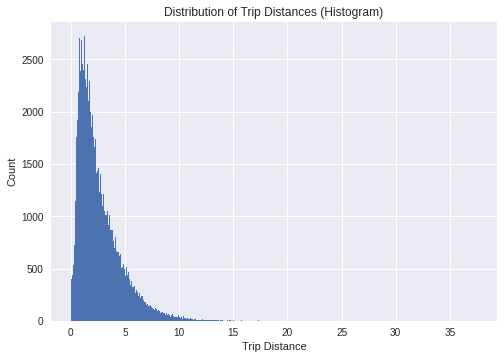

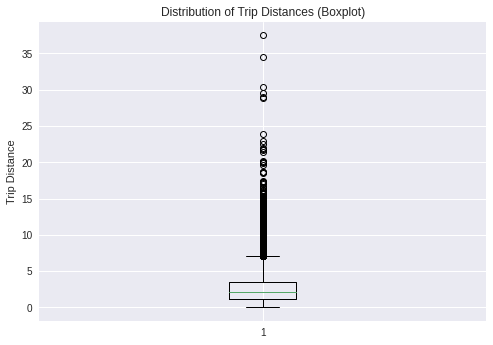

In [ ]:
distance = freq.collect()

plt.hist([row.trip_distance for row in distance], bins = 400)
plt.title('Distribution of Trip Distances (Histogram)')
plt.xlabel('Trip Distance')
plt.ylabel('Count')
plt.show()

plt.boxplot([row.trip_distance for row in distance])
plt.title('Distribution of Trip Distances (Boxplot)')
plt.ylabel('Trip Distance')
plt.show()

In [ ]:
freq = spark.sql( """SELECT longround(pickup_longitude) AS pickup_longitude, 
                            latround(pickup_latitude) AS pickup_latitude,
                            longround(dropoff_longitude) AS dropoff_longitude, 
                            latround(dropoff_latitude) AS dropoff_latitude,
                            count(*) AS cnt,
                            AVG(trip_distance) AS trip_distance
                            FROM data
                            WHERE trip_distance > """ + str(3.19) + """
                            GROUP BY pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
                            ORDER BY cnt DESC
                            LIMIT """ + str(10))
freq.show()

+----------------+------------------+-----------------+------------------+---+------------------+
|pickup_longitude|   pickup_latitude|dropoff_longitude|  dropoff_latitude|cnt|     trip_distance|
+----------------+------------------+-----------------+------------------+---+------------------+
|      -73.919909| 40.74281337199999|       -73.919909| 40.74281337199999|  8|5.5649999999999995|
|      -73.931881| 40.74730492799999|       -73.931881| 40.74730492799999|  8| 6.683750000000001|
|      -73.967797| 40.76077959599999|       -73.967797| 40.76077959599999|  7| 5.387142857142856|
|      -73.961811| 40.79671204399999|       -73.961811| 40.79671204399999|  7| 5.527142857142857|
|      -73.937867|40.756288039999994|       -73.937867|40.756288039999994|  5|             5.884|
|      -73.979769| 40.77425426399999|       -73.979769| 40.77425426399999|  5|             6.638|
|      -73.937867|40.756288039999994|       -73.937867|40.756288039999994|  4|             7.035|
|      -73.925895| 4

In [ ]:
plot1 = ny.collect()
plot2 = freq.collect()


plt.scatter([row.pickup_longitude for row in plot1],
            [row.pickup_latitude for row in plot1],
            s=1)
plt.scatter([row.dropoff_longitude for row in plot1],
            [row.dropoff_latitude for row in plot1],
            s=1)


for row in plot2:
  plt.plot([row.pickup_longitude, row.dropoff_longitude], [row.pickup_latitude, row.dropoff_latitude], color = "red")

plt.title('Top Ten Most Frequent Routes in New York (above treshold of 3.19 miles)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
  
plt.show()

### 1.3: Discussion

**Explain your code and discuss results**

In the United States, local bus stops are often about 1/4 mile or less apart, while express bus stops are 1/2 to 1 mile apart [1]. Based on this, it was initially assumed that the bus route distance should not be less than a quarter mile. Furthermore, the transit network of the German capital Berlin was used as a guide to determine a suitable threshold for the optimal route length of city buses in New York. In Berlin, 163 city bus routes of different bus types operate during the day and the route length was given as 1675 km (as of 2017) [2]. This results in an average line length of approximately 10.27 km or the equivalent of 6.38 miles. Taking the average line length of Berlin as an example, half of the average line length (3.19 miles) was set as the necessary threshold for the new bus lines in New York.

**Sources:**

[1] Transit Cooperative Research Program. "[TCRP Report 19: Guidelines for the Location and Design of Bus Stops](https://www.transitwiki.org/TransitWiki/index)." 1996.

[2] Berliner Verkehrsbetriebe. "[Geschaeftsbericht 2017](https://unternehmen.bvg.de/wp-content/uploads/2022/07/BVG-Geschaeftsbericht-2021.pdf)." 2017.

## Exercise 2

The taxi trips can be classified in two categories, depending on whether the client has given a tip or not (or alternatively in three categories - no tip, low percentage tip, high percentage tip). Propose a method to predict the class of a given trip (for the prediction, you cannot use the value of the tip).

### 2.1: Binary Classification (Tip / No Tip)

In [ ]:
# Creating pandas dataframe
ny_pd = ny.toPandas()

In [ ]:
ny_pd['Tip(0,1)'] = np.where(ny_pd['tip_amount'] > 0, "Tip", "No Tip")
ny_pd["CSH(0,1)"]=np.where(ny_pd['payment_type'] =="CSH", 1, 0)
ny_pd.head()

medallion                      hack_license  \
0  07290D3599E7A0D62097A346EFCC1FB5  E7750A37CAB07D0DFF0AF7E3573AC141   
1  0EC22AAF491A8BD91F279350C2B010FD  778C92B26AE78A9EBDF96B49C67E4007   
2  1390FB380189DF6BBFDA4DC847CAD14F  BE317B986700F63C43438482792C8654   
3  3B4129883A1D05BE89F2C929DE136281  7077F9FD5AD649AEACA4746B2537E3FA   
4  DFBFA82ECA8F7059B89C3E8B93DAA377  CF8604E72D83840FBA1978C2D2FC9CDB   

      pickup_datetime    dropoff_datetime  trip_time_in_secs  trip_distance  \
0 2013-01-01 00:00:00 2013-01-01 00:02:00                120           0.44   
1 2013-01-01 00:01:00 2013-01-01 00:03:00                120           0.71   
2 2013-01-01 00:01:00 2013-01-01 00:03:00                120           0.48   
3 2013-01-01 00:01:00 2013-01-01 00:03:00                120           0.61   
4 2013-01-01 00:02:00 2013-01-01 00:03:00                 60           0.39   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.956528        40.716976         -73.962440         40.715008   
1        -73.973145        40.752827         -73.965897         40.760445   
2        -74.004173        40.720947         -74.003838         40.726189   
3        -73.987373        40.724861         -73.983772         40.730995   
4        -73.981544        40.781475         -73.979439         40.784386   

  payment_type  fare_amount  surcharge  mta_tax  tip_amount  tolls_amount  \
0          CSH          3.5        0.5      0.5         0.0           0.0   
1          CSH          4.0        0.5      0.5         0.0           0.0   
2          CSH          4.0        0.5      0.5         0.0           0.0   
3          CRD          4.0        0.5      0.5         0.0           0.0   
4          CRD          3.0        0.5      0.5         0.7           0.0   

   total_amount Tip(0,1)  CSH(0,1)  
0           4.5   No Tip         1  
1           5.0   No Tip         1  
2           5.0   No Tip         1  
3           5.0   No Tip         0  
4           4.7      Tip         0

In [ ]:
corrmat = ny_pd.corr().abs()
pearson = corrmat['tip_amount']
pearson=pearson.sort_values(axis = 0, ascending = False)

# Drop variables connected with target variable
pearson.drop(index = ["Tip(0,1)", "total_amount"], inplace = True)
pearson

tip_amount           1.000000
CSH(0,1)             0.681545
fare_amount          0.342875
trip_distance        0.322276
trip_time_in_secs    0.292128
surcharge            0.089670
tolls_amount         0.071784
pickup_latitude      0.062109
mta_tax              0.048715
dropoff_longitude    0.031715
dropoff_latitude     0.018620
pickup_longitude     0.017562
Name: tip_amount, dtype: float64

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


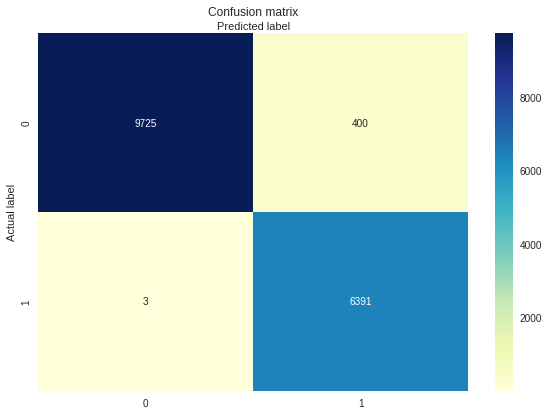

              precision    recall  f1-score   support

      No Tip      1.000     0.960     0.980     10125
         Tip      0.941     1.000     0.969      6394

    accuracy                          0.976     16519
   macro avg      0.970     0.980     0.975     16519
weighted avg      0.977     0.976     0.976     16519



In [ ]:
# Build feature/target arrays
x = ny_pd[["CSH(0,1)", "fare_amount", "trip_distance", "trip_time_in_secs", "surcharge", "tolls_amount"]]
y = ny_pd[['Tip(0,1)']]

# Create train/test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=10, stratify=y)

# Modeling
logreg = LogisticRegression()
logreg.fit(x_train,y_train)

# Prediction.
y_pred = logreg.predict(x_test)

# Plot the confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

class_names=["No Tip", "Tip"]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.show()

# Print metrics of model
print(classification_report(y_test, y_pred, digits=3))

### 2.2: Multi-Class Classification (No Tip / Low-Percentage Tip / High-Percentage Tip)

In [ ]:
ny_pd["tip_amount"].describe()

count    82594.000000
mean         0.944559
std          1.655216
min          0.000000
25%          0.000000
50%          0.000000
75%          1.600000
max         82.000000
Name: tip_amount, dtype: float64

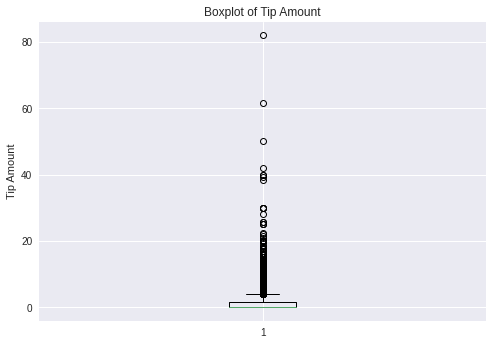

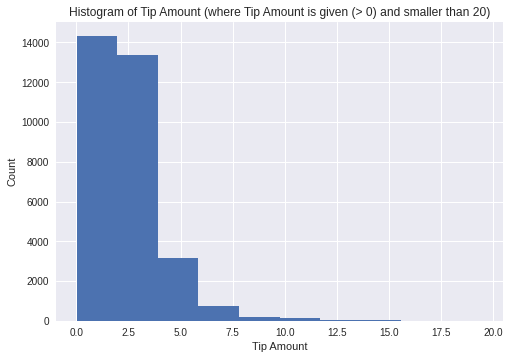

In [ ]:
plt.boxplot(ny_pd["tip_amount"])
plt.title("Boxplot of Tip Amount")
plt.ylabel('Tip Amount')
plt.show()

plt.hist(ny_pd[(ny_pd["tip_amount"] < 20) & (ny_pd["tip_amount"] > 0)]["tip_amount"])
plt.title("Histogram of Tip Amount (where Tip Amount is given (> 0) and smaller than 20)")
plt.ylabel('Count')
plt.xlabel('Tip Amount')
plt.show()

In [ ]:
print("Total rows: ", ny_pd.shape[0])
print("Total rows with tip amount higher than 0: ", ny_pd[ny_pd["tip_amount"] > 0].shape[0])
print("Total rows with tip amount higher than 2: ", ny_pd[ny_pd["tip_amount"] > 2].shape[0])
print("Total rows with tip amount higher than 5: ", ny_pd[ny_pd["tip_amount"] > 5].shape[0])
print("Total rows with tip amount higher than 10: ", ny_pd[ny_pd["tip_amount"] > 10].shape[0])
print("Total rows with tip amount higher than 15: ", ny_pd[ny_pd["tip_amount"] > 15].shape[0])
print("Total rows with tip amount higher than 20: ", ny_pd[ny_pd["tip_amount"] > 20].shape[0])

Total rows:  82594
Total rows with tip amount higher than 0:  31971
Total rows with tip amount higher than 2:  14637
Total rows with tip amount higher than 5:  1853
Total rows with tip amount higher than 10:  142
Total rows with tip amount higher than 15:  54
Total rows with tip amount higher than 20:  22


In [ ]:
# Creating new column containing ratio of tip to total amount (excluding tip amount)
ny_pd["tip_percentage"] = ny_pd["tip_amount"] / (ny_pd["total_amount"] - ny_pd["tip_amount"])
ny_pd["tip_percentage"].describe()

count    82594.000000
mean         0.077320
std          0.122582
min          0.000000
25%          0.000000
50%          0.000000
75%          0.187500
max          5.466667
Name: tip_percentage, dtype: float64

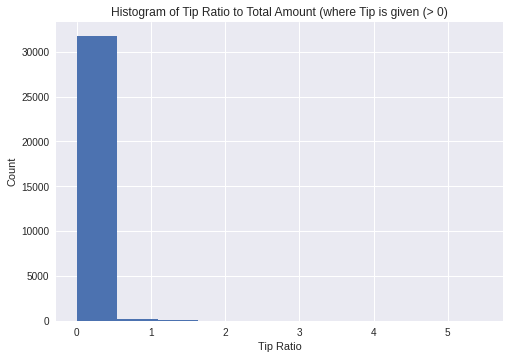

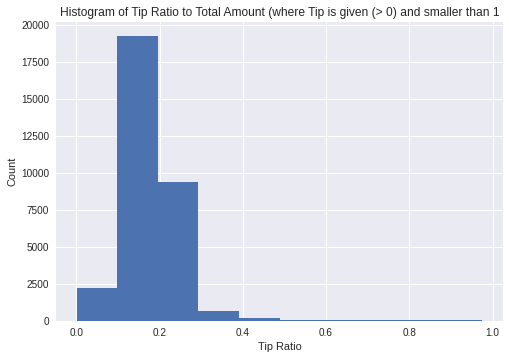

In [ ]:
plt.boxplot(ny_pd["tip_percentage"])
plt.title("Boxplot of Tip Ratio to Total Amount")
plt.ylabel('Tip Ratio')
plt.show()

plt.hist(ny_pd[(ny_pd["tip_percentage"] > 0)]["tip_percentage"])
plt.title("Histogram of Tip Ratio to Total Amount (where Tip is given (> 0)")
plt.ylabel('Count')
plt.xlabel('Tip Ratio')
plt.show()

plt.hist(ny_pd[(ny_pd["tip_percentage"] > 0) & (ny_pd["tip_percentage"] < 1)]["tip_percentage"])
plt.title("Histogram of Tip Ratio to Total Amount (where Tip is given (> 0) and smaller than 1")
plt.ylabel('Count')
plt.xlabel('Tip Ratio')
plt.show()

In [ ]:
# Creating new column containing three different tip classes
# 0.199 as the threshold between low percentage tip and high percentage tip (20+% tip is the standard rate in the US for excellent service)
ny_pd["tip_class"] = pd.cut(x=ny_pd["tip_percentage"], bins=[-1, 0, 0.199, ny_pd["tip_percentage"].max()], labels=["no_tip", "low_percentage_tip", "high_percentage_tip"])
ny_pd["tip_class"].value_counts()

no_tip                 50623
low_percentage_tip     22502
high_percentage_tip     9469
Name: tip_class, dtype: int64

In [ ]:
corrmat = ny_pd.corr().abs()
pearson = corrmat['tip_amount']
pearson=pearson.sort_values(axis = 0, ascending = False)

# Drop variables connected with target variable
#pearson.drop(index = ["tip_percentage", "total_amount", "fare_amount", "surcharge", "tolls_amount", "mta_tax"], inplace = True)

pearson

tip_amount           1.000000
tip_percentage       0.834748
CSH(0,1)             0.681545
total_amount         0.541171
fare_amount          0.342875
trip_distance        0.322276
trip_time_in_secs    0.292128
surcharge            0.089670
tolls_amount         0.071784
pickup_latitude      0.062109
mta_tax              0.048715
dropoff_longitude    0.031715
dropoff_latitude     0.018620
pickup_longitude     0.017562
Name: tip_amount, dtype: float64

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


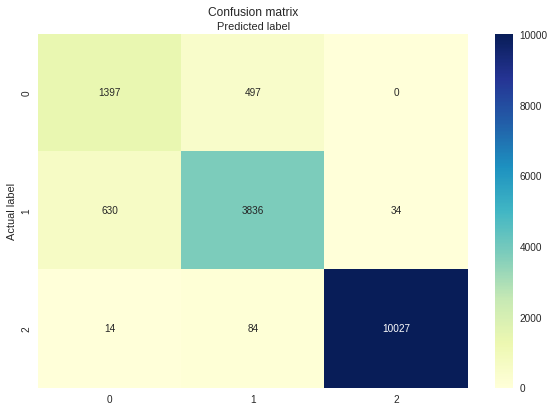

                     precision    recall  f1-score   support

high_percentage_tip      0.684     0.738     0.710      1894
 low_percentage_tip      0.868     0.852     0.860      4500
             no_tip      0.997     0.990     0.993     10125

           accuracy                          0.924     16519
          macro avg      0.850     0.860     0.855     16519
       weighted avg      0.926     0.924     0.925     16519



In [ ]:
# Build feature/target arrays
X = ny_pd[["CSH(0,1)", "total_amount", "fare_amount", "trip_distance", "trip_time_in_secs"]]
y = ny_pd[["tip_class"]].values.flatten()

# Create train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

# Modeling
#model = LogisticRegression(penalty='l2', max_iter=500, multi_class='ovr', solver='liblinear')
model = LogisticRegression()
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Plot the confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

class_names=["no_tip", "low_percentage_tip", "high_percentage_tip"]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.show()

# Print metrics of model
print(classification_report(y_test, y_pred, digits=3))

### 2.3: Discussion

Both for the binary classification under point 2.1 and for the multi-class classification under point 2.2, logistic regression was used as the classification method. For the binary classification, the only condition considered was whether a tip was given for a trip (tip_amount > 0) or not (tip_amount = 0). For the multi-class classification, a similar approach was applied to distinguish between no tip and low_percentage tip. The percentage of the tip was calculated from the ratio of the tip money to the total amount, which includes all costs of a cab trip (fare_amount, surcharge, mta_tax, tolls_amount) but specifically excludes the tip_amount. The distinction between low percentage tip and high percentage tip was derived from the common regulations in the USA. It can be noted that the standard rate for tip is 15%, while the rate for excellent service is 20% or more. Accordingly, the threshold between low percentage tip and high percentage tip was set at 0.199 (tip of 19.9%).

Looking at the evaluation of the two models, it can be seen that the overall accuracy of the models is very high at 97.6% (binary) and 92.4% (multi-class), which is mainly due to the accurate prediction of the class no tip. Predicting a tip is more difficult for the binary model than predicting no tip, and especially the high-percentage tips in the multi-class model have a precision of only 68.4%, making the predictions for this particular class very error-prone.



## Exercise 3

The third question intends to help taxi drivers to decide to which area of the city they should go next. To this end, we could have a web site/mobile app where the drivers could check the best area at a given moment. To support such application efficiently, it would be necessary to have a pre-computed index with the value for each area and period of time (e.g. combining the week day and a period of one hour). 

You should create the program to create such index. The output tuples should be something like: longitude latitude day_of_week hour value.

Define your own metric for the value of an area. Parameters that may be included in such metric include: the number of pickups in the area, the amount collected in the trip, the average time a taxi is idle in the area, etc.

Besides presenting the code, explain the rationale of your solution.

**Note:** SQL functions date(col), dayofweek(col) and hour(col) return, respectively, the date, day of week and hour of a datatime in column col.

In [ ]:
ny_pd['weekday'] = ny_pd['pickup_datetime'].dt.isocalendar().day
ny_pd['time_hour'] = ny_pd.pickup_datetime.apply(lambda x: x.hour)

**Calculating the Fare Level based on Cash Received Per Second and Cash Received Per Mile**

In [ ]:
ny_pd["cash_per_sec"] = ny_pd["fare_amount"] / ny_pd["trip_time_in_secs"]
ny_pd["cash_per_mile"] = ny_pd["fare_amount"] / ny_pd["trip_distance"]
fare = ny_pd[["pickup_longitude", "pickup_latitude", "weekday", "time_hour", "cash_per_sec", "cash_per_mile"]].copy()
fare.rename(columns = {"pickup_longitude": "longitude", "pickup_latitude": "latitude"}, inplace = True)
fare = fare.groupby(["longitude", "latitude", "weekday", "time_hour"]).mean()
fare['cash_per_sec_level'] = pd.cut(fare['cash_per_sec'], bins=np.linspace(fare['cash_per_sec'].min(), fare['cash_per_sec'].max(), 11), labels= [1,2,3,4,5,6,7,8,9,10], include_lowest = True)
fare['cash_per_mile_level'] = pd.cut(fare['cash_per_mile'], bins=np.linspace(fare['cash_per_mile'].min(), fare['cash_per_mile'].max(), 11), labels= [1,2,3,4,5,6,7,8,9,10], include_lowest = True)
fare['cash_per_sec_level'] =fare['cash_per_sec_level'].astype(float)
fare['cash_per_mile_level'] =fare['cash_per_mile_level'].astype(float)
fare['fare_level'] = (fare['cash_per_sec_level'] + fare['cash_per_mile_level']) / 2
fare.sort_values('fare_level', axis = 0, ascending = False)

cash_per_sec  cash_per_mile  \
longitude  latitude  weekday time_hour                                
-74.006927 40.739822 2       3              1.666667   10000.000000   
-74.010384 40.778877 2       4              1.785714       2.304147   
-74.027306 40.752182 2       11             1.083333    1083.333333   
-74.011375 40.713387 2       3              1.166667      11.627907   
-73.994835 40.741230 2       5              1.250000     441.176471   
...                                              ...            ...   
-73.988098 40.732143 2       1              0.014286       8.450704   
           40.724083 2       1              0.012963       5.185185   
           40.722691 2       6              0.017500       4.233871   
           40.718636 2       8              0.017708       4.187192   
-73.920013 40.732906 2       3              0.018056       4.924242   

                                        cash_per_sec_level  \
longitude  latitude  weekday time_hour                       
-74.006927 40.739822 2       3                        10.0   
-74.010384 40.778877 2       4                        10.0   
-74.027306 40.752182 2       11                        7.0   
-74.011375 40.713387 2       3                         7.0   
-73.994835 40.741230 2       5                         7.0   
...                                                    ...   
-73.988098 40.732143 2       1                         1.0   
           40.724083 2       1                         1.0   
           40.722691 2       6                         1.0   
           40.718636 2       8                         1.0   
-73.920013 40.732906 2       3                         1.0   

                                        cash_per_mile_level  fare_level  
longitude  latitude  weekday time_hour                                   
-74.006927 40.739822 2       3                         10.0        10.0  
-74.010384 40.778877 2       4                          1.0         5.5  
-74.027306 40.752182 2       11                         2.0         4.5  
-74.011375 40.713387 2       3                          1.0         4.0  
-73.994835 40.741230 2       5                          1.0         4.0  
...                                                     ...         ...  
-73.988098 40.732143 2       1                          1.0         1.0  
           40.724083 2       1                          1.0         1.0  
           40.722691 2       6                          1.0         1.0  
           40.718636 2       8                          1.0         1.0  
-73.920013 40.732906 2       3                          1.0         1.0  

[78408 rows x 5 columns]

In [ ]:
ny_pd[["cash_per_mile", "cash_per_sec", "trip_time_in_secs", "trip_distance", "fare_amount"]].sort_values('cash_per_mile', axis = 0, ascending = False).head(20)

cash_per_mile  cash_per_sec  trip_time_in_secs  trip_distance  \
42937   10000.000000      1.666667                 60           0.01   
57099    2600.000000      0.866667                 60           0.02   
53403    2600.000000      0.866667                 60           0.02   
36840    2500.000000      0.104167                240           0.01   
55582    1733.333333      0.866667                 60           0.03   
2144     1500.000000      0.250000                 60           0.01   
76544    1083.333333      1.083333                 60           0.06   
50726    1000.000000      0.333333                 60           0.02   
77817     866.666667      0.866667                 60           0.06   
46093     825.000000      0.275000                 60           0.02   
810       800.000000      0.011111                720           0.01   
20652     680.000000      1.133333                 60           0.10   
39804     650.000000      0.012037                540           0.01   
57310     650.000000      0.433333                120           0.08   
79134     537.500000      0.119444                180           0.04   
23053     454.545455      0.833333                 60           0.11   
26023     450.000000      0.015000                300           0.01   
24791     450.000000      0.012500                360           0.01   
54675     441.176471      1.250000                 60           0.17   
77207     416.666667      0.009921               1260           0.03   

       fare_amount  
42937        100.0  
57099         52.0  
53403         52.0  
36840         25.0  
55582         52.0  
2144          15.0  
76544         65.0  
50726         20.0  
77817         52.0  
46093         16.5  
810            8.0  
20652         68.0  
39804          6.5  
57310         52.0  
79134         21.5  
23053         50.0  
26023          4.5  
24791          4.5  
54675         75.0  
77207         12.5

**Calculating the Tip Level based on the Amount of the Tip**

In [ ]:
tip = ny_pd[["pickup_longitude", "pickup_latitude", "weekday", "time_hour", 'tip_amount']].copy()
tip.rename(columns = {"pickup_longitude": "longitude", "pickup_latitude": "latitude","tip_amount":"tip_mean"}, inplace = True)
tip = tip.groupby(["longitude", "latitude", "weekday", "time_hour"]).mean()
tip['tip_level'] = pd.cut(tip['tip_mean'], bins=np.linspace(tip['tip_mean'].min(), tip['tip_mean'].max(), 11), labels= [1,2,3,4,5,6,7,8,9,10], include_lowest = True)
tip['tip_level'] =tip['tip_level'].astype(float)
tip.sort_values('tip_mean', axis = 0, ascending = False)

tip_mean  tip_level
longitude  latitude  weekday time_hour                     
-73.985504 40.718407 2       2             82.00       10.0
-73.953323 40.788353 2       2             61.64        8.0
-73.976753 40.683380 2       2             50.00        7.0
-73.972557 40.743416 2       3             42.00        6.0
-73.953262 40.788521 2       0             40.00        5.0
...                                          ...        ...
-73.984520 40.753426 2       11             0.00        1.0
           40.754417 2       1              0.00        1.0
-73.984512 40.724754 2       1              0.00        1.0
           40.736912 2       11             0.00        1.0
-73.920013 40.732906 2       3              0.00        1.0

[78408 rows x 2 columns]

**Calculating the Difference Level based on the Difference between Dropoffs and Pickups at a Certain location**

In [ ]:
dropoffs = ny_pd[["dropoff_longitude", "dropoff_latitude", "weekday", "time_hour", "medallion"]].copy()
dropoffs.rename(columns = {"medallion":"total_dropoffs","dropoff_longitude": "longitude", "dropoff_latitude": "latitude","tip_amount":"tip_mean"}, inplace = True)
dropoffs = dropoffs.groupby(["longitude", "latitude", "weekday", "time_hour"]).count()
pickups = ny_pd[["pickup_longitude", "pickup_latitude", "weekday", "time_hour", "medallion"]].copy()
pickups.rename(columns = {"medallion":"total_pickups","pickup_longitude": "longitude", "pickup_latitude": "latitude","tip_amount":"tip_mean"}, inplace = True)
pickups = pickups.groupby(["longitude", "latitude", "weekday", "time_hour"]).count()
pick_drop_diff = dropoffs.merge(pickups, how='outer', left_index=True, right_index=True)
pick_drop_diff = pick_drop_diff.fillna(0)
pick_drop_diff["difference"] = pick_drop_diff["total_dropoffs"] - pick_drop_diff["total_pickups"]
pick_drop_diff['difference_level'] = pd.cut(pick_drop_diff["difference"], bins=np.linspace(pick_drop_diff["difference"].min(), pick_drop_diff["difference"].max(), 11), labels= [1,2,3,4,5,6,7,8,9,10], include_lowest = True)
pick_drop_diff['difference_level'] = pick_drop_diff['difference_level'].astype(float)
pick_drop_diff.sort_values("difference", axis = 0, ascending = False)

total_dropoffs  total_pickups  \
longitude  latitude  weekday time_hour                                  
-73.941620 40.801151 2       0                     2.0            0.0   
-73.979645 40.727283 2       2                     2.0            0.0   
-73.949181 40.785187 2       1                     2.0            0.0   
-73.991196 40.750343 2       4                     2.0            0.0   
-73.990700 40.750317 2       11                    2.0            0.0   
...                                                ...            ...   
-73.986534 40.731358 2       2                     0.0            4.0   
-73.991959 40.749355 2       2                     0.0            4.0   
-74.001785 40.721485 2       2                     0.0            5.0   
-73.987083 40.729523 2       2                     0.0            5.0   
-73.981827 40.743450 2       2                     0.0            6.0   

                                        difference  difference_level  
longitude  latitude  weekday time_hour                                
-73.941620 40.801151 2       0                 2.0              10.0  
-73.979645 40.727283 2       2                 2.0              10.0  
-73.949181 40.785187 2       1                 2.0              10.0  
-73.991196 40.750343 2       4                 2.0              10.0  
-73.990700 40.750317 2       11                2.0              10.0  
...                                            ...               ...  
-73.986534 40.731358 2       2                -4.0               3.0  
-73.991959 40.749355 2       2                -4.0               3.0  
-74.001785 40.721485 2       2                -5.0               2.0  
-73.987083 40.729523 2       2                -5.0               2.0  
-73.981827 40.743450 2       2                -6.0               1.0  

[158905 rows x 4 columns]

In [ ]:
recommend = fare.merge(tip, how = "outer", left_index=True, right_index=True).merge(pick_drop_diff, how = "outer", left_index=True, right_index=True)
recommend = recommend[["fare_level", "tip_level", "difference_level"]]
recommend = recommend.fillna(1)
recommend["total_level"] = np.round((recommend["fare_level"] + recommend["tip_level"] + recommend["difference_level"])/3 , decimals = 1)
recommend = recommend.reset_index()
recommend.sort_values(["weekday", "time_hour", "total_level"], ascending = [True, True, False])

longitude   latitude  weekday  time_hour  fare_level  tip_level  \
11414  -74.004128  40.752621        2          0         1.0        5.0   
138011 -73.953262  40.788521        2          0         1.0        5.0   
9448   -74.005241  40.741371        2          0         1.0        1.0   
13635  -74.002708  40.760632        2          0         1.0        1.0   
24629  -73.996559  40.749409        2          0         1.0        1.0   
...           ...        ...      ...        ...         ...        ...   
126142 -73.959618  40.809361        2         12         1.0        1.0   
126471 -73.959404  40.780113        2         12         1.0        1.0   
132823 -73.955727  40.768303        2         12         1.0        1.0   
134158 -73.955109  40.769978        2         12         1.0        1.0   
143349 -73.950317  40.775890        2         12         1.0        1.0   

        difference_level  total_level  
11414                7.0          4.3  
138011               7.0          4.3  
9448                10.0          4.0  
13635               10.0          4.0  
24629               10.0          4.0  
...                  ...          ...  
126142               5.0          2.3  
126471               5.0          2.3  
132823               5.0          2.3  
134158               5.0          2.3  
143349               5.0          2.3  

[158905 rows x 8 columns]

In [ ]:
weekday = int(input('Please enter the weekday: '))
hour = int(input('Please enter the time: '))
top10 = recommend[(recommend["weekday"] == weekday) & (recommend["time_hour"] == hour)][["longitude","latitude","total_level"]].nlargest(10, "total_level")[["longitude","latitude"]]
print("Your top 10 locations for weekday " + str(weekday) + " at " + str(hour) + " o'clock:")
top10

Please enter the weekday: 2
Please enter the time: 12
Your top 10 locations for weekday 2 at 12 o'clock:


longitude   latitude
38270 -73.991623  40.759781
43    -74.019073  40.716347
68    -74.017654  40.706791
172   -74.017006  40.704845
192   -74.016945  40.704494
320   -74.016632  40.704601
479   -74.016220  40.706863
652   -74.015869  40.715420
833   -74.015419  40.709801
842   -74.015396  40.708092

### 3.1: Discussion

In order to provide a recommendation to the user for the best location on a certain day of the week at a certain time, a metric was generated that includes three factors that have a positive impact on taxi demand and income during a taxi ride. 

The first factor was a categorization of the regular taxi fare. This was done by first calculating the amount per second and the amount per mile obtained for a taxi ride from a given location. Subsequently, these two sub-factors were divided into ten categories according to their characteristics. In the last step, the factor for the total amount for a location was calculated from the mean value of the subfactors cash per second and cash per mile .

For the second factor, the tip was considered. In this case, the tip, which a taxi driver receives for a ride from a certain location, was categorized into ten categories.

For the last factor, the pick-ups and drop-offs at a specific location were considered. In this case, locations with as many drop-offs as possible and as few pick-ups as possible  were of particular interest, because that implies that enough people are available for pick-up (high demand for taxi rides at a certain location). For this purpose, the difference between the number of drop-offs and the number of pick-ups was calculated for each location. The resulting differences were then divided into ten categories according to their characteristics.

In the last step, the total attractiveness of a location for a taxi driver was calculated. For this purpose, the metric total_level was generated, which consists of the mean value of the three factors mentioned above (fare_level, tip_level, difference_level).

Finally, based on the input function, an individual recommendation system was created for the user, so that the user can manually enter the day of the week and the time (full hour) to receive the top ten locations for the entered hour and day of the week.

## Exercise 4

The fourth question intends to help define the location of taxi ranks (the places where taxis stop waiting for collecting clients) in a way that tries to minimize the distance a client needs to travel to reach the taxi rank.

Consider that you want to establish, at least, 100 taxi ranks but no more than 150 - present the code that defines the number and locations of the ranks.

**Note:** This dataset is for NYC taxis. So, pickups outside of the city are infrequent and not representative of the demand in such areas. As such, you should focus on pickups in a square that includes NYC (it is ok if the square includes parts outside of the city). Use, for example, the following square:
```
northLatitude = 40.86
southLatitude = 40.68
eastLongitude = -74.03
westLongitude = -73.92
```

**Suggestion:** Plot your results as a heatmap, with the color being a measurement of the value of the taxi rank; use the visual feedback to enhance your solution.

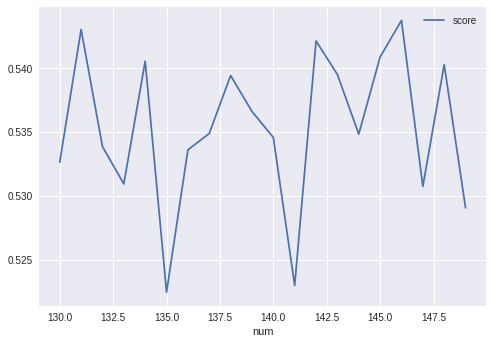

In [ ]:
dataset = ny
# Function to perform clustering of dataset data with K clusters, 
# returning the Silhouette score
def evaluate( dataset, k):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(dataset)
    predictions = model.transform(dataset)
    evaluator = ClusteringEvaluator()
    score = evaluator.evaluate(predictions)
    return score



# Create the features column
assembler = VectorAssembler(inputCols=('pickup_longitude','pickup_latitude'),outputCol="features")
dataset = assembler.transform(dataset)


# For each value from 2 to 40 compute the clusters and the score
df1 = pd.DataFrame(columns=['num','score'])
for i in range(130,150):
    df1 = pd.concat([df1,pd.Series({"num": i, "score": evaluate(dataset,i)}).to_frame().T], ignore_index=True)

# Plot the scores    
df1.plot( x="num", y="score")
plt.title('Number of clusters and Corresponding Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

In [ ]:
k = int(df1.nlargest(1,"score")["num"].values[0])
print("The best perfoming kluster number is:",k)

The best perfoming kluster number is: 146


In [ ]:
kmeans = KMeans().setK(k).setSeed(1)
model = kmeans.fit(dataset)
centers = model.clusterCenters()
predictions = model.transform(dataset)

predictionsPD = predictions.toPandas()
# Display results, using the cluster number as the color
predictionsPD.plot.scatter(x="pickup_longitude",y="pickup_latitude",c="prediction",s=1,cmap='gist_ncar')
plt.title('Visualization of 146 Predicted Clusters in New York')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

/usr/local/lib/python3.8/dist-packages/pyspark/sql/pandas/conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


In [ ]:
centersPD0df = pd.DataFrame (centers, columns = ['latitude','longitude'])
centersPD0df.reset_index(inplace=True)
centersPD0df = centersPD0df.rename(columns = {'index':'prediction'})

In [ ]:
predictionsPD["count"] = predictionsPD.groupby(['prediction'])['prediction'].count()
new = predictionsPD[["prediction","count"]]
merged=centersPD0df.merge(new, on="prediction")
merged=merged.groupby(['prediction'])['prediction'].count()
merged=pd.DataFrame (merged, columns = ['prediction'])

In [ ]:
df5 = merged.merge(centersPD0df, left_index=True, right_on='prediction')
df5.rename(columns={"prediction_x": "value of the taxi rank"}, inplace=True)

In [ ]:
p= df5.plot.scatter(x="longitude", y="latitude",c="value of the taxi rank",s=9,cmap="rainbow")
p.plot()
plt.title('Visualization of 146 Taxi Ranks in New York')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### 4.1 Discussion

Since this data set is for taxis in New York City, and out-of-town pickups are rare and not representative of demand in New York City, the data set focused exclusively on taxi pickups in a square that includes New York City. All other trips outside the New York metropolitan area were filtered out.

The k-Means algorithm was used to determine the number and location of suitable taxi ranks so that the distance a customer must travel to reach the nearest taxi rank is as short as possible. The k-Means algorithm is a computational method that can be used for grouping objects (cluster analysis). The algorithm is able to determine the respective centers of the clusters from a set of similar objects with a previously known number of groups.

The k-means algorithm computes in a for loop for each k (number of taxi ranks) the accuracy, how well the individual values can be assigned to a cluster. The number of clusters in the range of 100 and 150 was chosen because the requirements of the task require that there be at least 100 but at most 150 taxi ranks in New York City.

The function n largest is then applied to choose the K with which all points are assigned to a cluster. 

In the next step, the cluster centers are plotted and visualized on a heat map. The scale on the right indicates how many points are in the respective cluster. The higher the number, the redder the cluster center appears, which means that most trips originate from this cluster, so it is best suited for a cab ranking, since most trips start here.


## Exercise 5

Propose a problem that you think would be useful to solve with the given dataset.

**Explain the problem you propose to solve**

In this task, the question is whether the taxi rides can be used to identify specific areas or communities within the city. It is assumed that a large part of the taxi rides take place within an urban area of the city of New York, so that individual areas/communities of the city of New York can be derived and visualized on the basis of the data set with cab data. This question is investigated by applying the Louvain algorithm.

In [1]:
gridDF = spark.sql( """SELECT medallion, hack_license, pickup_datetime,
                                    dropoff_datetime, trip_time_in_secs, trip_distance,
                                    longround(pickup_longitude) AS pickup_longitude, 
                                    latround(pickup_latitude) AS pickup_latitude,
                                    longround(dropoff_longitude) AS dropoff_longitude, 
                                    latround(dropoff_latitude) AS dropoff_latitude, 
                                    payment_type, fare_amount, mta_tax, 
                                    tip_amount, tolls_amount, total_amount
                                  FROM data
                                  WHERE pickup_longitude >= """ + str(eastLongitude) + """ AND
                                  pickup_longitude <=  """ + str(westLongitude) + """ AND
                                  dropoff_longitude >=  """ + str(eastLongitude) + """ AND
                                  dropoff_longitude <=  """ + str(westLongitude) + """ AND
                                  pickup_latitude <= """ + str(northLatitude) + """ AND
                                  pickup_latitude >= """ + str(southLatitude) + """ AND
                                  dropoff_latitude <=  """ + str(northLatitude) + """ AND
                                  dropoff_latitude >=  """ + str(southLatitude))

gridDF = gridDF[(gridDF.pickup_longitude> xlim[0]) & (gridDF.pickup_longitude < xlim[1])]
gridDF = gridDF[(gridDF.dropoff_longitude> xlim[0]) & (gridDF.dropoff_longitude < xlim[1])]
gridDF = gridDF[(gridDF.pickup_latitude> ylim[0]) & (gridDF.pickup_latitude < ylim[1])]
gridDF = gridDF[(gridDF.dropoff_latitude> ylim[0]) & (gridDF.dropoff_latitude < ylim[1])]

com = gridDF.toPandas()
com["pickup_longitude"] = com["pickup_longitude"].astype(str)
com['pickup_latitude'] = com['pickup_latitude'].astype(str)
com["source"] = com["pickup_longitude"] + "," + com['pickup_latitude']
com["dropoff_longitude"] = com["dropoff_longitude"].astype(str)
com['dropoff_latitude'] = com['dropoff_latitude'].astype(str)
com["target"] = com["dropoff_longitude"] + "," + com['dropoff_latitude']

NameError: ignored

In [ ]:
g = nx.Graph()
#g.add_weighted_edges_from(pdf[['source', 'target', 'total_amount']].values)
g.add_edges_from(com[['source', 'target']].values)
partition = community_louvain.best_partition(g)

In [ ]:
part = pd.DataFrame.from_dict(partition, orient='index')
part = part.reset_index()
part['Location'] = part['index']
part[['Longitude', 'Latitude']] = part['Location'].str.split(',', expand=True)
part["Longitude"] = part["Longitude"].astype(float)
part['Latitude'] = part['Latitude'].astype(float)
part['Community'] = part[0]
part = part.drop(['index', 0, 'Location'], axis=1)
part.groupby(['Community'])['Community'].count().nlargest(4)

In [ ]:
part  = part.loc[part['Community'].isin([0,2,3,4])]

In [ ]:
groups = part.groupby('Community')
for name, group in groups:
    plt.plot(group.Longitude, group.Latitude, marker='o', linestyle='', markersize=8, label=name)

plt.title('Main Four Communities in New York')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [ ]:
p = part.plot.scatter(x="Longitude", y="Latitude",c="Community",s=9,cmap="rainbow")
p.plot()
plt.title('Main Four Communities in New York')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### 5.1: Discussion

The Louvain algorithm operates as input with with one source and one destination column, but the dataset with the taxi rides always has longitude and latitude as pick-up and drop-off coordinates respectively. 

For this reason, the first step is to convert the longitude and latitude for pick-up and drop-off coordinates into a string and combine them in a column. Since the respective coordinates are needed separately again for the final visualization, longitude and latitude are separated by a comma. The algorithm now computes different communities, which are grouped and afterwards the four largest communities in the metropolitan area of New York City are selected. 

In the next step all points of these four communities are plotted, colored and assigned to the respective communities. It turns out that the assumption was correct and individual urban areas of the New York City can be roughly identified on the graph.